In [1]:
import pandas as pd
from tabulate import tabulate

import numpy as np
import datetime
from datetime import date, timedelta

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as tkr

linelist_cases_1 = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/linelist/linelist_cases_06.csv'
linelist_cases_2 = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/linelist/linelist_cases_07.csv'
linelist_deaths = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/linelist/linelist_deaths.csv'

In [2]:
date_min = date.today() - timedelta(14)
date_max = date.today() - timedelta(1)

def vaxStatus(date_pos, date1, date2, date3, cases=1):
    if cases == 1:
        if date3 > 6: return 'boosted'
        elif date2 > 13: return 'fullyvax'
        elif date1 >= 0: return 'partialvax'
        else: return 'unvax'
    elif cases == 0:
        if (date_pos - date3).days > 6: return 'boosted'
        elif (date_pos - date2).days > 13: return 'fullyvax'
        elif (date_pos - date1).days >= 0: return 'partialvax'
        else: return 'unvax'

def castAge(age):
    if age == -1: return 'missing'
    elif age < 5: return '0_4'
    elif age < 12: return '5_11'
    elif age < 18: return '12_17'
    elif age < 30: return '18_29'
    elif age < 40: return '30_39'
    elif age < 50: return '40_49'
    elif age < 60: return '50_59'
    elif age < 70: return '60_69'
    elif age < 80: return '70_79'
    else: return '80+'

ages = [x for x in range(-1, 150)]
age_cat = dict(zip(ages, [castAge(x) for x in ages]))

In [3]:
# Pull latest death linelist and wrangle
df = pd.read_csv(linelist_deaths, usecols=['date', 'age', 'date_positive', 'date_dose1', 'date_dose2', 'date_dose3', 'brand1'])
for c in ['date', 'date_positive', 'date_dose1', 'date_dose2', 'date_dose3']: df[c] = pd.to_datetime(df[c], errors='coerce').dt.date
df = df[(df.date >= date_min) & (df.date <= date_max)]

# Ensure no null vax dates (future date as placeholder), shift 14 days for Cansino, then encode vax status and age group
for c in ['date_dose1', 'date_dose2', 'date_dose3']: df[c] = df[c].fillna(date.today() + timedelta(1))
df.loc[df.brand1.isin(['Cansino']), 'date_dose2'] = df.date_dose1 + timedelta(14)
df['status'] = df.apply(lambda x: vaxStatus(x['date_positive'], x['date_dose1'], x['date_dose2'], x['date_dose3'], cases=0), axis=1)
df = df.replace(date.today() + timedelta(1), np.nan)  # Remove placeholder dates
df.age = df.age.map(age_cat)  # Encode age group

# Tabulate
df = df[~df.age.isin(['missing','0_4','5_11','12_17'])].groupby(['age', 'status']).size().to_frame('deaths').reset_index()
df = df[~df.status.isin(['partialvax'])].reset_index(drop=True)
df = pd.concat([df, df.groupby(['status']).sum().reset_index()],axis=0).fillna('Overall').reset_index(drop=True)
df.head(len(df))

,age,status,deaths
0,18_29,fullyvax,7
1,18_29,unvax,5
2,30_39,boosted,6
3,30_39,fullyvax,13
4,30_39,unvax,7
5,40_49,boosted,17
6,40_49,fullyvax,20
7,40_49,unvax,17
8,50_59,boosted,27
9,50_59,fullyvax,50


In [4]:
# Pull latest 2 case linelists and wrangle
col_cases = ['date', 'age', 'days_dose1', 'days_dose2', 'days_dose3', 'brand1']
cf = pd.concat([pd.read_csv(linelist_cases_1, usecols=col_cases),
                pd.read_csv(linelist_cases_2, usecols=col_cases)],axis=0)
for c in ['date']: cf[c] = pd.to_datetime(cf[c], errors='coerce').dt.date
cf = cf[(cf.date >= date_min - timedelta(7)) & (cf.date <= date_max - timedelta(7))] # backshift to account for lag between cases and deaths

# Ensure no null vax dates (-1 as placeholder), shift 14 days for Cansino, then encode vax status and age group
for c in ['days_dose1', 'days_dose2', 'days_dose3']: cf[c] = cf[c].fillna(-1)
cf.loc[cf.brand1.isin(['c']), 'days_dose2'] = cf.days_dose1 - 14
cf['status'] = cf.apply(lambda x: vaxStatus(x['date'], x['days_dose1'], x['days_dose2'], x['days_dose3'], cases=1), axis=1)
cf.age = cf.age.map(age_cat)  # Encode age group

# Tabulate
cf = cf[~cf.age.isin(['missing','0_4','5_11','12_17'])].groupby(['age', 'status']).size().to_frame('cases').reset_index()
cf = cf[~cf.status.isin(['partialvax'])].reset_index(drop=True)
cf = pd.concat([cf, cf.groupby(['status']).sum().reset_index()],axis=0).fillna('Overall').reset_index(drop=True)
cf.head(len(cf))

,age,status,cases
0,18_29,boosted,52657
1,18_29,fullyvax,52817
2,18_29,unvax,4183
3,30_39,boosted,56575
4,30_39,fullyvax,34507
5,30_39,unvax,3822
6,40_49,boosted,37800
7,40_49,fullyvax,15158
8,40_49,unvax,2071
9,50_59,boosted,25015


In [5]:
# Merge frames and compute incidence, then pivot
df = pd.merge(cf,df, on=['age','status'], how='left')
df['cfr'] = df.deaths/df.cases * 100
try: assert len(df[df.cfr < 0]) == 0
except AssertionError:
    print('Negative CFR(s) detected')
    df.head(len(df))
df = df.pivot(index='age', columns='status', values=['cfr']).fillna(0).reset_index()
df.columns = ['age','Boosted','Fully Vaccinated','Unvaccinated']
df = df[['age','Unvaccinated','Fully Vaccinated','Boosted']]
df.head(len(df))

,age,Unvaccinated,Fully Vaccinated,Boosted
0,18_29,0.119531,0.013253,0.000000
1,30_39,0.183150,0.037674,0.010605
2,40_49,0.820859,0.131944,0.044974
3,50_59,2.002861,0.532481,0.107935
4,60_69,3.802281,1.441718,0.233012
5,70_79,7.905138,3.517139,0.855365
6,80+,12.621359,10.178306,3.318443
7,Overall,1.927948,0.356641,0.099018


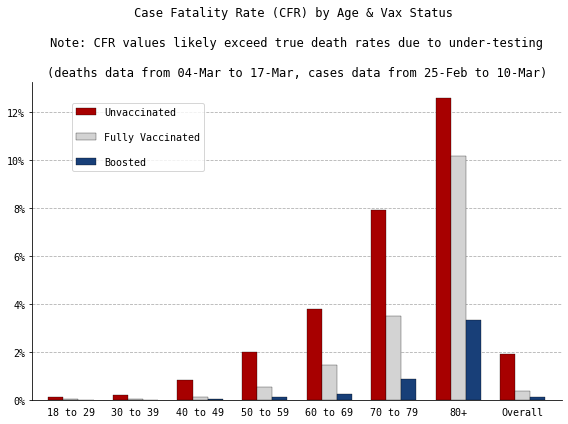

In [6]:
# Chart
def percFormat(x, pos): return ('{:,}'.format(x) + '%').replace('.0', '')

plt.rcParams.update({'font.size': 10,
                     'font.family':'Monospace',
                     'grid.linestyle':'dashed'})
plt.rcParams["figure.figsize"] = [8,6]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

df.age = df.age.str.replace('_', ' to ')
df.plot(x='age', y=['Unvaccinated','Fully Vaccinated','Boosted'], kind='bar',
        color=['#a70000','lightgray','#183f78'],
        align='center',
        width=0.7,linewidth=0.3,
        edgecolor='black',ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.grid(True)
ax.set_axisbelow(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.2, 0.95), ncol=1, labelspacing = 1.5, frameon=True, fancybox=True)
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(percFormat))
plt.tick_params(bottom=False)

plt.title('Case Fatality Rate (CFR) by Age & Vax Status \n\n' + 'Note: CFR values likely exceed true death rates due to under-testing\n\n'
          '(deaths data from ' + date_min.strftime('%d-%b') + ' to ' + date_max.strftime('%d-%b') + ', ' +
            'cases data from ' + (date_min-timedelta(7)).strftime('%d-%b') + ' to ' + (date_max-timedelta(7)).strftime('%d-%b') + ')')
plt.xlabel('')
plt.ylabel('')
plt.savefig('src_deaths/deaths_vaxstatus_cfr.png', bbox_inches='tight', pad_inches=0.2,dpi=400)
plt.show()